# What deep learning sees while learning from complementary labels.

This notebook shows what the deep learning take attention if it is trained with complementary labels. In this context, the complementary labels mean wrong labels: cat image is labelled "dog" or "bird".<br>
It is possible to train a model using complementary labels, just by letting the deep learning to learn the training image is NOT the labelled class. So, it learns to get the wrong answers, corresponding to the complementary labels, and notices the image class is something that is not label as.<br>
https://arxiv.org/abs/1705.07541

The aim of the notebook is to show what the model sees after trained with the complementary labels. <br>
Since the model learns from the wrong classes, what are the features the model take attention on?<br>
Is it different from the model trained with the regular right labels?

In order to clarify what features are seen through the models, I used Grad-Cam to visualize what part in the image is extracted.<br>
https://arxiv.org/abs/1610.02391

## Preparation
I used a part of Caltech101 images for input dataset.<br>
In order to make the problem simple, I used only the "airplanes", "watch" and "Leopard" images.<br>
These classes are chosen for it contains enough amount of files, more than 200. Although  there are 800 airplane images, I sampled only 200 out of them, to get about the equal amount as wath and leopard images.<br>
http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [0]:
import os
import requests
import tarfile
import sys
import numpy as np
import pandas as pd
from PIL import Image
from skimage import transform
import matplotlib.pyplot as plt
import cv2
import random

### Download images

In [0]:
def download_file(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)
    return local_filename

In [0]:
def untar_file(file_path):
  with tarfile.open(file_path) as f:
    f.extractall()
    f.close()

In [0]:
def get_file_dict(directory):
    sub_dir = os.listdir(directory)
    files_dict = {}
    for s in sub_dir:
        files_dict[s] = [os.path.join(directory, os.path.join(s, f)) for f in os.listdir(os.path.join(directory, s))]
    return files_dict

In [0]:
pwd = os.getcwd()
caltech_dir = os.path.join(pwd,"101_ObjectCategories")
annot_dir = os.path.join(pwd, "Annotations")

In [0]:
if not os.path.exists(os.path.join(pwd, "101_ObjectCategories.tgz")):
  tar_img_file = download_file("http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz")
else:
  tar_img_file = "101_ObjectCategories.tgz"

if not os.path.exists(caltech_dir):
  untar_file(os.path.join(pwd, tar_img_file))

### A list of image classes and their amount of files

In [8]:
caltech_img_file_list = get_file_dict(caltech_dir)
for k,v in caltech_img_file_list.items():
  print(k, len(v))

cellphone 59
scissors 39
sea_horse 57
flamingo 67
dalmatian 67
lobster 41
buddha 85
crocodile 50
gerenuk 34
crocodile_head 51
wrench 39
rooster 49
elephant 64
mayfly 40
BACKGROUND_Google 468
schooner 63
cup 57
crab 73
okapi 39
Faces_easy 435
trilobite 86
euphonium 64
cougar_face 69
platypus 34
sunflower 85
hawksbill 100
butterfly 91
gramophone 51
chandelier 107
menorah 87
joshua_tree 64
flamingo_head 45
kangaroo 86
dolphin 65
pizza 53
nautilus 55
stapler 45
pyramid 57
ketch 114
airplanes 800
watch 239
water_lilly 37
dragonfly 68
pagoda 47
garfield 34
saxophone 40
soccer_ball 64
scorpion 84
strawberry 35
revolver 82
ceiling_fan 47
ferry 67
pigeon 45
yin_yang 60
brontosaurus 43
crayfish 70
Leopards 200
beaver 46
grand_piano 99
emu 53
cannon 43
wild_cat 34
lotus 66
anchor 42
minaret 76
mandolin 43
tick 49
cougar_body 47
brain 98
stegosaurus 59
starfish 86
ibis 80
ant 42
bonsai 128
wheelchair 59
binocular 33
chair 62
ewer 85
inline_skate 31
rhino 59
laptop 81
electric_guitar 75
hedgehog 54

### Preprocess imgages
Resizing images to 299 * 299 RGB and converting them to numpy array.

In [0]:
# get dict of label to image file list
caltech_dict = {0:["watch", caltech_img_file_list["watch"]], 
                1:["Leopards", caltech_img_file_list["Leopards"]], 
                2:["airplanes", random.sample(caltech_img_file_list["airplanes"], 200)]} # choosing only 200 files from airplanes

In [238]:
data_num = len(caltech_dict[0][1]) + len(caltech_dict[1][1]) + len(caltech_dict[2][1])
for k,v in caltech_dict.items():
  print("{0}:\t{1} images".format(v[0], len(v[1])))
print("total:\t{0} images".format(data_num))

watch:	239 images
Leopards:	200 images
airplanes:	200 images
total:	639 images


In [0]:
def show_img(img):
  plt.imshow(img)
  plt.show()

0 watch
/content/101_ObjectCategories/watch/image_0013.jpg


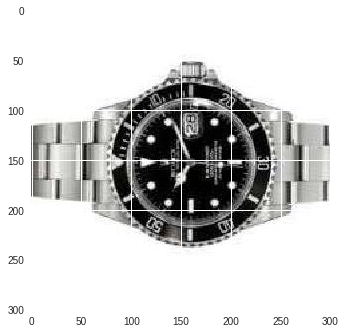

1 Leopards
/content/101_ObjectCategories/Leopards/image_0122.jpg


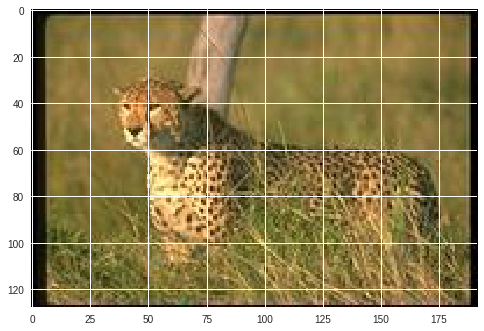

2 airplanes
/content/101_ObjectCategories/airplanes/image_0298.jpg


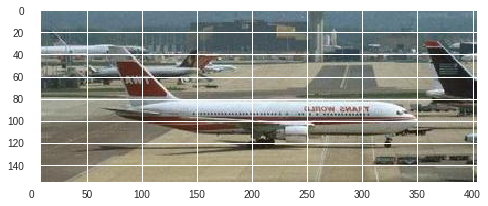

In [155]:
}for k,v in caltech_dict.items():
  print(k,v[0])
  imgs = random.sample(v[1], 1)
  for i in imgs:
    print(i)
    img = Image.open(i)
    show_img(img)

In [24]:
# convert image files to numpy array
np_data = np.zeros((data_num,299,299,3))
np_labels = np.zeros((data_num, 1))
c = 0

for k,v in caltech_dict.items():
  print(k,v[0],len(v[1]))
  for l in v[1]:
    img = Image.open(l)
    if img.mode != "RGB":
      img = img.convert("RGB")
    np_img = np.asarray(img)
    np_img = transform.resize(np_img, (299,299))
    np_data[c] = np_img
    np_labels[c] = k
    c += 1
    
# save them
np.savez_compressed("dataset.npz", x=np_data)
np.savez_compressed("labels.npz", y=np_labels)

0 watch 239


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1 Leopards 200
2 airplanes 200


In [0]:
np_data=None
np_labels=None

## Define Xception model
Using Keras with Tensorflow backend and defining Xception model

In [27]:
import keras
from keras.utils import np_utils
from keras.models import Model

from keras import layers
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics

from sklearn.model_selection import train_test_split
import math

Using TensorFlow backend.


### Load dataset

In [0]:
classes = 3

In [29]:
x = np.load("dataset.npz")["x"]
y = np.load("labels.npz")["y"]

# splitting 80% for training and 20% for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                len(y_train), 
                                                                x_test.shape, 
                                                                len(y_test)))

x = None
y = None

x train:(511, 299, 299, 3)
y train:511
x test:(128, 299, 299, 3)
y test:128


In [30]:
# preprocess
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

y_train = np_utils.to_categorical(y_train, classes)
y_test = np_utils.to_categorical(y_test, classes)
print(y_train.shape, y_test.shape)

(511, 3) (128, 3)


In [0]:
# the shape of image is (299,299,3) array
input_shape = (299,299,3)

In [0]:
# defining Xception
def Xception(input_shape=(299,299,3), classes=3):
    img_input = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    
    model = Model(img_input, x, name='xception')

    return model

### Train with regular labels
First train a model with regular, right class, labels. 

In [0]:
# model trained with regular labels
model = Xception()

In [0]:
# define optimization, using ADAM with learning rate of 0.00001 with decay and amsgrad
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
# early stopping
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [0]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=True, 
    vertical_flip=True 
)

datagen.fit(x_train)

In [39]:
# train model
batch_size = 16
epochs = 1000

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs, 
                    verbose=1,
                    shuffle=True,
                    callbacks=[es_cb])

Epoch 1/1000
31/31 [==============================] - 63s 2s/step - loss: 0.8236 - acc: 0.6610 - val_loss: 0.7336 - val_acc: 0.6641
Epoch 2/1000
31/31 [==============================] - 45s 1s/step - loss: 0.5627 - acc: 0.7715 - val_loss: 0.5570 - val_acc: 0.7344
Epoch 3/1000
31/31 [==============================] - 45s 1s/step - loss: 0.4763 - acc: 0.8223 - val_loss: 0.4605 - val_acc: 0.8125
Epoch 4/1000
31/31 [==============================] - 45s 1s/step - loss: 0.3943 - acc: 0.8485 - val_loss: 0.3758 - val_acc: 0.8672
Epoch 5/1000
31/31 [==============================] - 46s 1s/step - loss: 0.3802 - acc: 0.8605 - val_loss: 0.3618 - val_acc: 0.8594
Epoch 6/1000
15/31 [=============>................] - ETA: 22s - loss: 0.2800 - acc: 0.9206

31/31 [==============================] - 46s 1s/step - loss: 0.2982 - acc: 0.9031 - val_loss: 0.3142 - val_acc: 0.8906
Epoch 7/1000
31/31 [==============================] - 46s 1s/step - loss: 0.2761 - acc: 0.9011 - val_loss: 0.2656 - val_acc: 0.9062
Epoch 8/1000
31/31 [==============================] - 46s 1s/step - loss: 0.2919 - acc: 0.9031 - val_loss: 0.2386 - val_acc: 0.9141
Epoch 9/1000
31/31 [==============================] - 46s 1s/step - loss: 0.2180 - acc: 0.9311 - val_loss: 0.2785 - val_acc: 0.8984
Epoch 10/1000
31/31 [==============================] - 46s 1s/step - loss: 0.2207 - acc: 0.9151 - val_loss: 0.3262 - val_acc: 0.8750
Epoch 11/1000
31/31 [==============================] - 47s 2s/step - loss: 0.2519 - acc: 0.9091 - val_loss: 0.1851 - val_acc: 0.9219
Epoch 12/1000
25/31 [=======================>......] - ETA: 8s - loss: 0.2101 - acc: 0.9272

31/31 [==============================] - 46s 1s/step - loss: 0.2057 - acc: 0.9332 - val_loss: 0.1808 - val_acc: 0.9297
Epoch 13/1000
31/31 [==============================] - 46s 1s/step - loss: 0.1917 - acc: 0.9254 - val_loss: 0.2099 - val_acc: 0.9141
Epoch 14/1000
31/31 [==============================] - 45s 1s/step - loss: 0.1743 - acc: 0.9395 - val_loss: 0.1873 - val_acc: 0.9141
Epoch 15/1000
31/31 [==============================] - 45s 1s/step - loss: 0.1821 - acc: 0.9355 - val_loss: 0.1948 - val_acc: 0.9141
Epoch 00015: early stopping


In [40]:
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

128/128 [==============================] - 4s 32ms/step
[0.19479084014892578, 0.9140625]


### Train a model with complementary labels

In [42]:
x = np.load("dataset.npz")["x"]
y = np.load("labels.npz")["y"]

# splitting 80% for training and 20% for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                len(y_train), 
                                                                x_test.shape, 
                                                                len(y_test)))

x = None
y = None

x train:(511, 299, 299, 3)
y train:511
x test:(128, 299, 299, 3)
y test:128


In [0]:
# generate complementary labels for training targets
# if the right label if 0, then the complementary label is either 1 or 2.

y_ctrain = np.zeros((len(y_train),1))
for i,v in enumerate(y_train):
    if v == 0:
        y_ctrain[i] = np.random.choice([1,2],1)
    elif v == 1:
        y_ctrain[i] = np.random.choice([0,2],1)
    elif v == 2:
        y_ctrain[i] = np.random.choice([0,1],1)

In [0]:
# generate complementary labels for test targets
# if the right label if 0, then the complementary label is either 1 or 2.

y_ctest = np.zeros((len(y_test), 1))
for i,v in enumerate(y_test):
    if v == 0:
        y_ctest[i] = np.random.choice([1,2],1)
    elif v == 1:
        y_ctest[i] = np.random.choice([0,2],1)
    elif v == 2:
        y_ctest[i] = np.random.choice([0,1],1)

In [45]:
# preprocess
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

y_ctrain = np_utils.to_categorical(y_ctrain, classes)
y_ctest = np_utils.to_categorical(y_ctest, classes)
y_train = np_utils.to_categorical(y_train, classes)
y_test = np_utils.to_categorical(y_test, classes)
print(y_ctrain.shape, y_ctest.shape)

(511, 3) (128, 3)


In [0]:
# defining sigmoid loss for complementary label training
def sigmoid_loss (target, output):
    return 1 / (1 + math.e ** K.categorical_crossentropy(target, output))

In [0]:
# defining pseudo accuracy for complementary label training
# this does not calculate right accuracy rate
def caccuracy (target, output):
    return 1 - metrics.categorical_accuracy(target, output)

In [0]:
# a model for complementary label
cmodel = Xception()

In [0]:
# define optimization, using ADAM with learning rate of 0.00001 with decay and amsgrad
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)
cmodel.compile(loss=sigmoid_loss,
               optimizer=opt,
               metrics=[caccuracy])

In [0]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=True, 
    vertical_flip=True 
)

datagen.fit(x_train)

In [52]:
# train model
batch_size = 16
epochs = 1000

cmodel.fit_generator(datagen.flow(x_train, y_ctrain, batch_size=batch_size),
                     steps_per_epoch=x_train.shape[0] // batch_size,
                     validation_data=(x_test, y_ctest),
                     epochs=epochs, 
                     verbose=1,
                     shuffle=True,
                     callbacks=[es_cb])

Epoch 1/1000
31/31 [==============================] - 61s 2s/step - loss: 0.2175 - caccuracy: 0.8488 - val_loss: 0.1595 - val_caccuracy: 0.8438
Epoch 2/1000
31/31 [==============================] - 46s 1s/step - loss: 0.1476 - caccuracy: 0.8586 - val_loss: 0.1033 - val_caccuracy: 0.8750
Epoch 3/1000
31/31 [==============================] - 46s 1s/step - loss: 0.1065 - caccuracy: 0.8828 - val_loss: 0.0826 - val_caccuracy: 0.8828
Epoch 4/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0777 - caccuracy: 0.8989 - val_loss: 0.0718 - val_caccuracy: 0.9062
Epoch 5/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0618 - caccuracy: 0.9234 - val_loss: 0.0594 - val_caccuracy: 0.9141
Epoch 6/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0566 - caccuracy: 0.9192 - val_loss: 0.0542 - val_caccuracy: 0.9141
Epoch 7/1000
12/31 [==========>...................] - ETA: 26s - loss: 0.0699 - caccuracy: 0.9062

31/31 [==============================] - 47s 2s/step - loss: 0.0622 - caccuracy: 0.9214 - val_loss: 0.0463 - val_caccuracy: 0.9297
Epoch 8/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0439 - caccuracy: 0.9495 - val_loss: 0.0465 - val_caccuracy: 0.9141
Epoch 9/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0507 - caccuracy: 0.9374 - val_loss: 0.0394 - val_caccuracy: 0.9297
Epoch 10/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0457 - caccuracy: 0.9293 - val_loss: 0.0440 - val_caccuracy: 0.9297
Epoch 11/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0412 - caccuracy: 0.9474 - val_loss: 0.0347 - val_caccuracy: 0.9453
Epoch 12/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0479 - caccuracy: 0.9292 - val_loss: 0.0386 - val_caccuracy: 0.9375
Epoch 13/1000
15/31 [=============>................] - ETA: 21s - loss: 0.0415 - caccuracy: 0.9375

31/31 [==============================] - 46s 1s/step - loss: 0.0442 - caccuracy: 0.9274 - val_loss: 0.0341 - val_caccuracy: 0.9531
Epoch 14/1000
31/31 [==============================] - 45s 1s/step - loss: 0.0357 - caccuracy: 0.9410 - val_loss: 0.0319 - val_caccuracy: 0.9531
Epoch 15/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0419 - caccuracy: 0.9335 - val_loss: 0.0294 - val_caccuracy: 0.9609
Epoch 16/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0421 - caccuracy: 0.9352 - val_loss: 0.0291 - val_caccuracy: 0.9688
Epoch 17/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0331 - caccuracy: 0.9532 - val_loss: 0.0250 - val_caccuracy: 0.9688
Epoch 18/1000
31/31 [==============================] - 45s 1s/step - loss: 0.0349 - caccuracy: 0.9435 - val_loss: 0.0232 - val_caccuracy: 0.9609
Epoch 19/1000
15/31 [=============>................] - ETA: 21s - loss: 0.0274 - caccuracy: 0.9667

31/31 [==============================] - 46s 1s/step - loss: 0.0282 - caccuracy: 0.9575 - val_loss: 0.0263 - val_caccuracy: 0.9609
Epoch 20/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0271 - caccuracy: 0.9617 - val_loss: 0.0239 - val_caccuracy: 0.9766
Epoch 21/1000
31/31 [==============================] - 46s 1s/step - loss: 0.0273 - caccuracy: 0.9574 - val_loss: 0.0359 - val_caccuracy: 0.9375
Epoch 00021: early stopping


In [54]:
# calculating the right accuracy, compared to the right labels
cpred = cmodel.predict(x_test)

score = 0
for i in range(len(y_test)):
    if np.argmax(y_test[i]) == np.argmax(cpred[i]):
        score += 1
print(score / len(y_test))

0.8671875


## Visualize Grad-Cam
Now that the models for regular label and complementary label are trained, let's visualize extracted features in the image using Grad-Cam.

In [0]:
import cv2

# set to learning phase
K.set_learning_phase(1)

In [0]:
# convert image file to numpy array
def convert_img_to_np(img, size=(299,299)):
  img = Image.open(img)
  if img.mode != "RGB":
    img = img.convert("RGB")
  np_img = np.asarray(img)
  return transform.resize(np_img, size)

In [0]:
# convert numpy array to image
def convert_np_to_img(np_img):
  np_img *= 255
  return Image.fromarray(np.uint8(np_img))

In [0]:
# standardize pixels
def preprocess_img(np_img):  
  np_img = np.expand_dims(np_img, axis=0)

  np_img = np_img.astype('float32')
  return np_img / 255.0

In [0]:
# get model output for image
def get_model_output(model, np_img):
  label = np.argmax(model.predict(np_img)[0])
  print("label:\t{0}".format(label))
  return model.output[:, label]

In [0]:
# get conv function
def get_grad_func(model, layer, model_output):
  conv_output = model.get_layer(layer).output 
  grads = K.gradients(model_output, conv_output)[0] 
  return K.function([model.input], [conv_output, grads]) 

In [0]:
# get output from the function
def get_grads_val(gradient_function, np_img):
  output, grads_val = gradient_function([np_img])
  return output[0], grads_val[0]

In [0]:
# get grad cam
def get_grad_cam(output, grads_val, np_img, size=(299,299)):
  weights = np.mean(grads_val, axis=(0, 1))
  cam = np.dot(output, weights)
  
  cam = cv2.resize(cam, size, cv2.INTER_LINEAR) 
  cam = np.maximum(cam, 0) 
  cam = cam / cam.max()
  
  gradcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
  gradcam = cv2.cvtColor(gradcam, cv2.COLOR_BGR2RGB)
  return (np.float32(gradcam) + np_img / 2)

In [0]:
# grad cam
def grad_cam(model, img, layer):
  np_img = convert_img_to_np(img)
  prep_np_img = preprocess_img(np_img)
  model_output = get_model_output(model, prep_np_img)    
  gradient_function = get_grad_func(model, layer, model_output)    
  output, grads_val = get_grads_val(gradient_function, prep_np_img)

  gradcam = get_grad_cam(output, grads_val, np_img)

  return gradcam

In [0]:
# show grad cam image
def show_gradcam(model, img, layer):
  gcam = grad_cam(model, img, layer)
  show_img(convert_np_to_img(gcam))

In [0]:
# show original and grad cam image
def show_img_and_gradcam(model, img, layer):
  show_img(convert_img_to_np(img))
  show_gradcam(model, img, layer)

###  visualize original image, grad cam with regular model and grad cam with complementary label model

/content/101_ObjectCategories/watch/image_0129.jpg
ORIGINAL


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


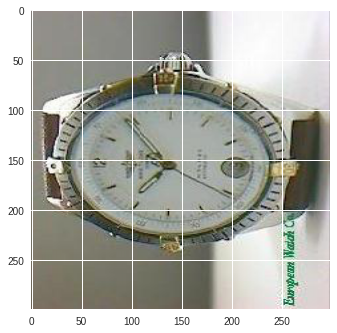

GRAD CAM REGULAR MODEL
label:	0


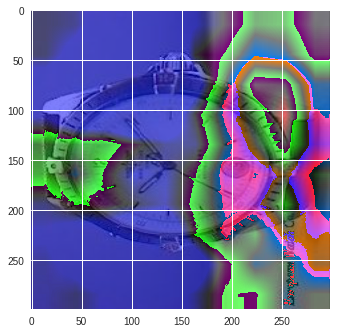

GRAD CAM COMPLEMENTARY MODEL
label:	0


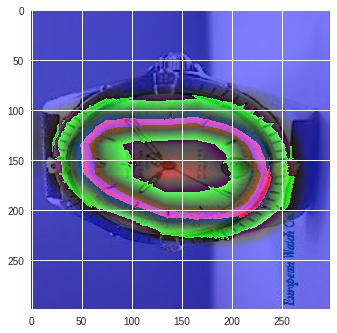

/content/101_ObjectCategories/watch/image_0035.jpg
ORIGINAL


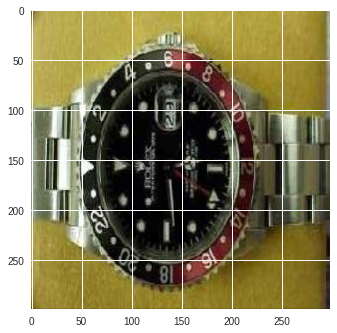

GRAD CAM REGULAR MODEL
label:	0


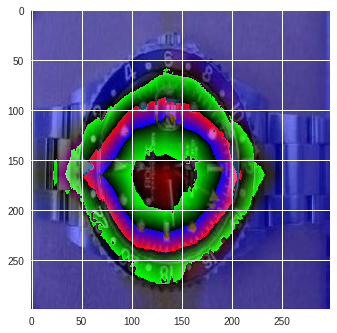

GRAD CAM COMPLEMENTARY MODEL
label:	0


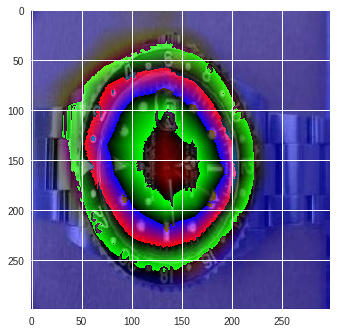

/content/101_ObjectCategories/watch/image_0216.jpg
ORIGINAL


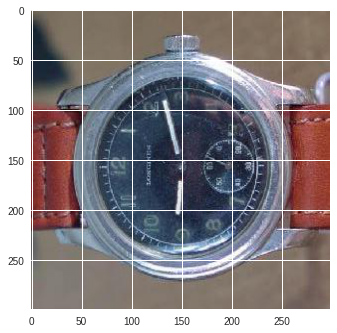

GRAD CAM REGULAR MODEL
label:	2


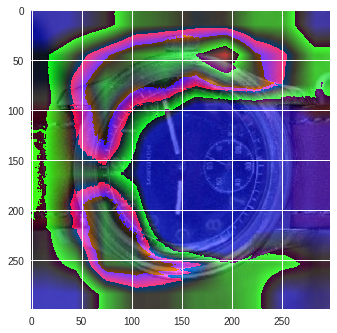

GRAD CAM COMPLEMENTARY MODEL
label:	0


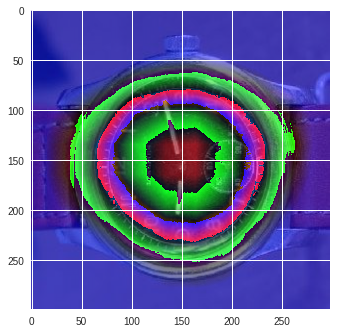

/content/101_ObjectCategories/watch/image_0048.jpg
ORIGINAL


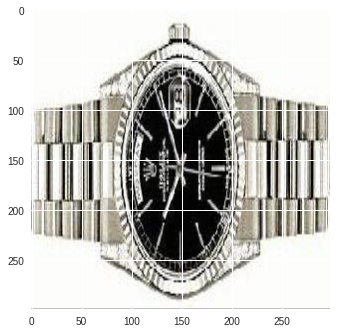

GRAD CAM REGULAR MODEL
label:	0


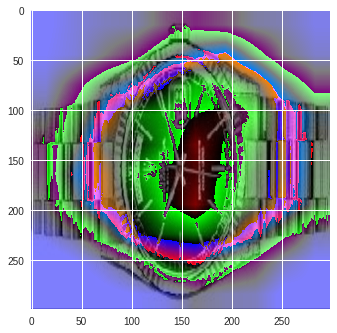

GRAD CAM COMPLEMENTARY MODEL
label:	0


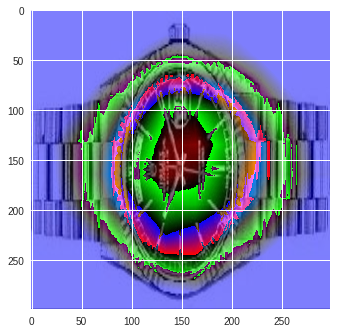

/content/101_ObjectCategories/watch/image_0234.jpg
ORIGINAL


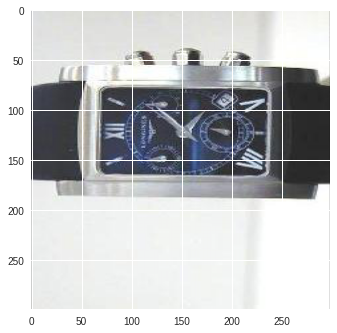

GRAD CAM REGULAR MODEL
label:	0


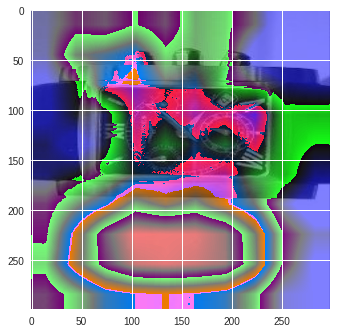

GRAD CAM COMPLEMENTARY MODEL
label:	0


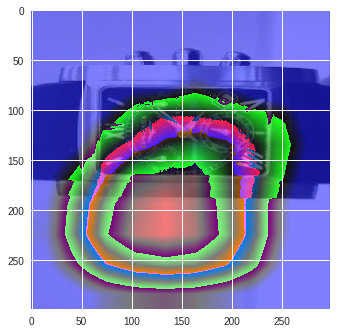

In [249]:
# WATCH
for j in range(5):
  img = caltech_dict[0][1][j]
  print(img)
  print("ORIGINAL")
  show_img(convert_img_to_np(img))
  print("GRAD CAM REGULAR MODEL")
  show_gradcam(model, img, "block14_sepconv2_act")
  print("GRAD CAM COMPLEMENTARY MODEL")
  show_gradcam(cmodel, img, "block14_sepconv2_act")

/content/101_ObjectCategories/Leopards/image_0129.jpg
ORIGINAL


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


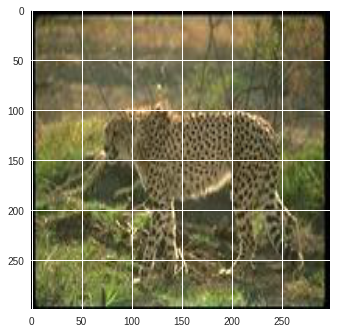

GRAD CAM REGULAR MODEL
label:	1


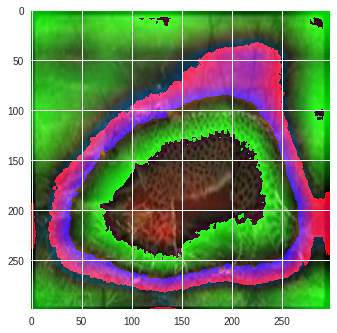

GRAD CAM COMPLEMENTARY MODEL
label:	1


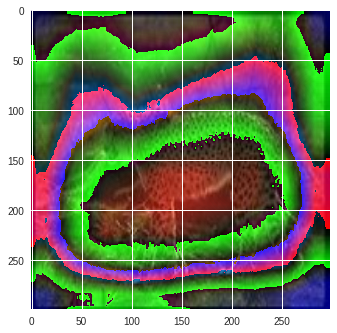

/content/101_ObjectCategories/Leopards/image_0035.jpg
ORIGINAL


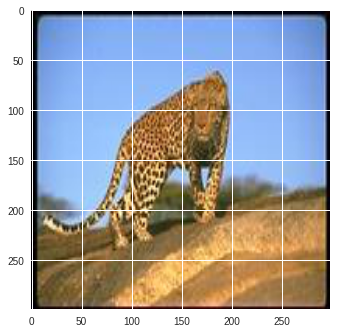

GRAD CAM REGULAR MODEL
label:	1


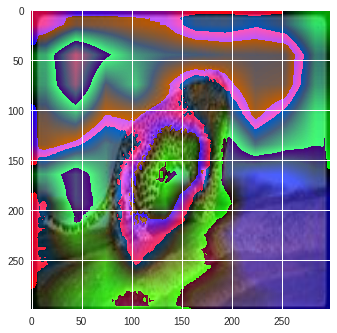

GRAD CAM COMPLEMENTARY MODEL
label:	1


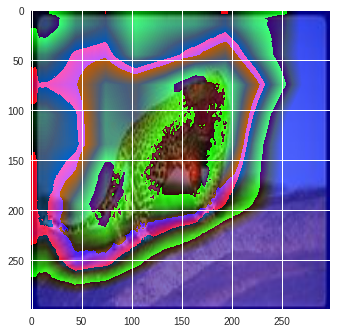

/content/101_ObjectCategories/Leopards/image_0048.jpg
ORIGINAL


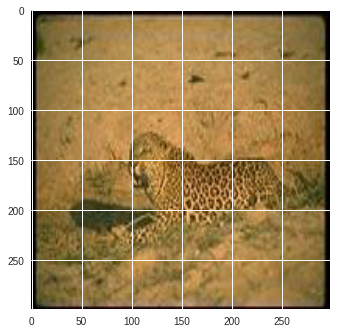

GRAD CAM REGULAR MODEL
label:	1


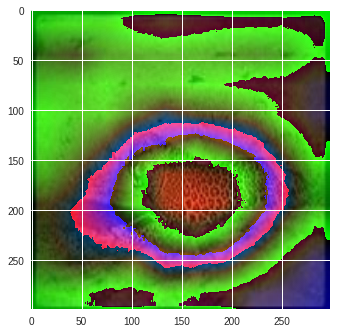

GRAD CAM COMPLEMENTARY MODEL
label:	1


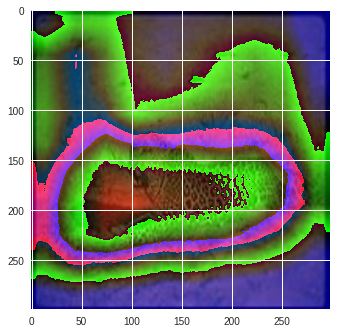

/content/101_ObjectCategories/Leopards/image_0139.jpg
ORIGINAL


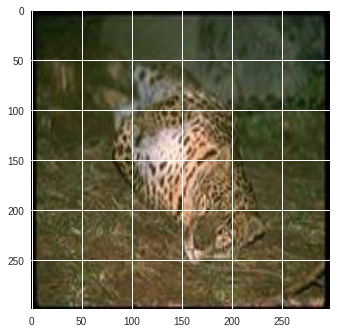

GRAD CAM REGULAR MODEL
label:	1


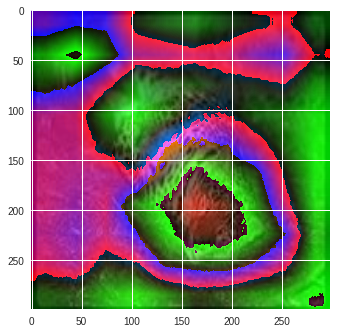

GRAD CAM COMPLEMENTARY MODEL
label:	1


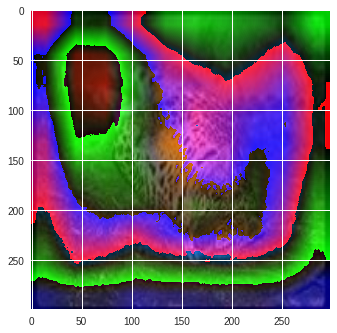

/content/101_ObjectCategories/Leopards/image_0060.jpg
ORIGINAL


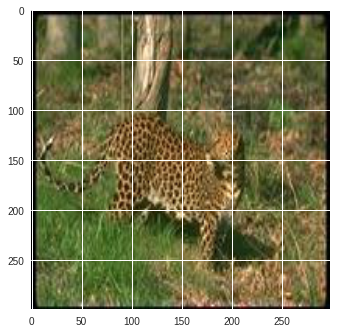

GRAD CAM REGULAR MODEL
label:	1


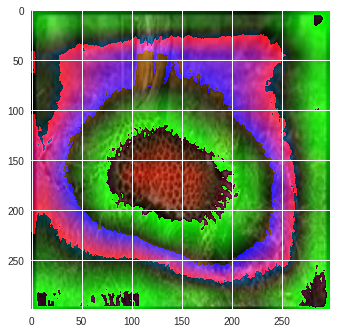

GRAD CAM COMPLEMENTARY MODEL
label:	1


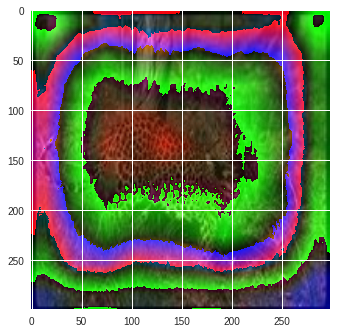

In [250]:
# LEOPARD
for j in range(5):
  img = caltech_dict[1][1][j]
  print(img)
  print("ORIGINAL")
  show_img(convert_img_to_np(img))
  print("GRAD CAM REGULAR MODEL")
  show_gradcam(model, img, "block14_sepconv2_act")
  print("GRAD CAM COMPLEMENTARY MODEL")
  show_gradcam(cmodel, img, "block14_sepconv2_act")

/content/101_ObjectCategories/airplanes/image_0598.jpg
ORIGINAL


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


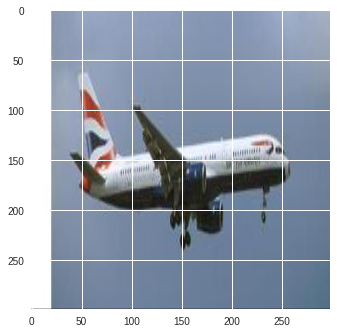

GRAD CAM REGULAR MODEL
label:	2


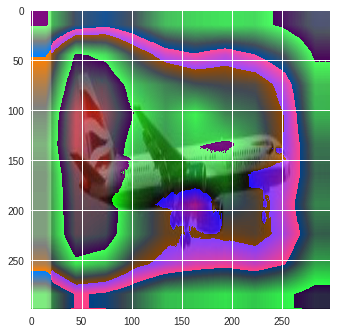

GRAD CAM COMPLEMENTARY MODEL
label:	2


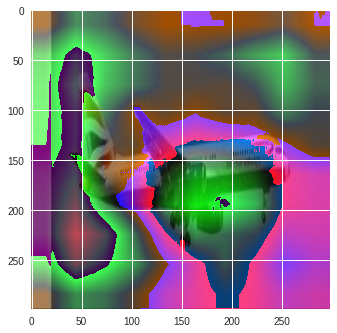

/content/101_ObjectCategories/airplanes/image_0788.jpg
ORIGINAL


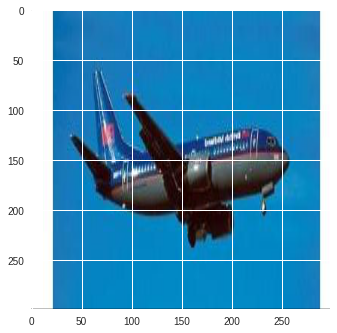

GRAD CAM REGULAR MODEL
label:	2


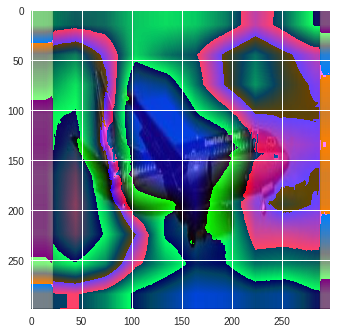

GRAD CAM COMPLEMENTARY MODEL
label:	2


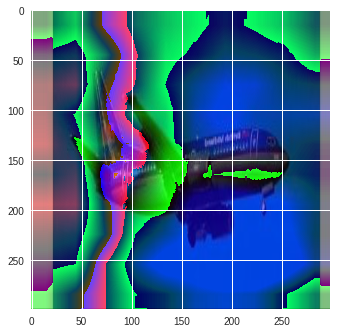

/content/101_ObjectCategories/airplanes/image_0418.jpg
ORIGINAL


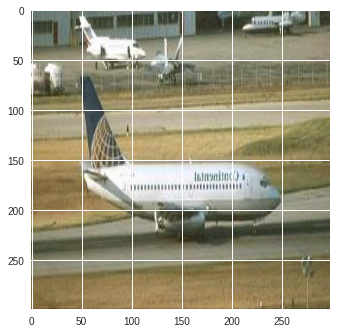

GRAD CAM REGULAR MODEL
label:	2


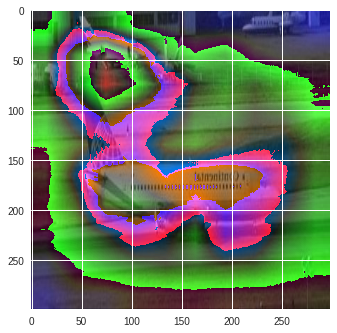

GRAD CAM COMPLEMENTARY MODEL
label:	2


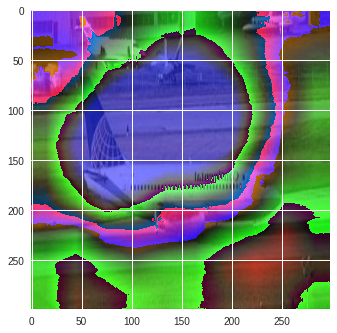

/content/101_ObjectCategories/airplanes/image_0509.jpg
ORIGINAL


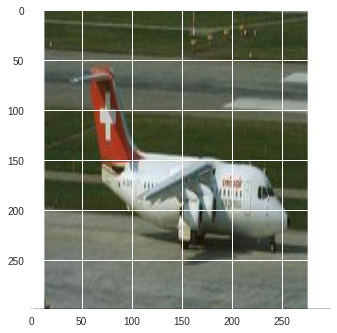

GRAD CAM REGULAR MODEL
label:	2


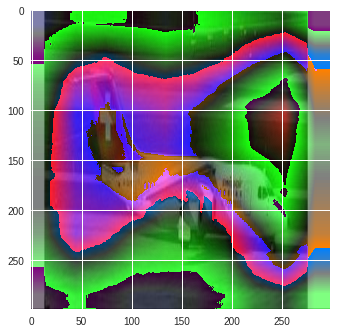

GRAD CAM COMPLEMENTARY MODEL
label:	2


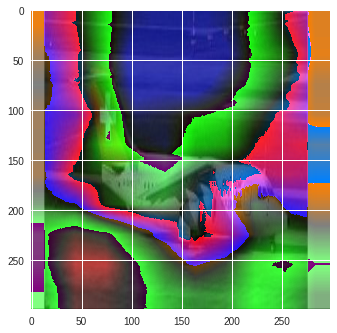

/content/101_ObjectCategories/airplanes/image_0455.jpg
ORIGINAL


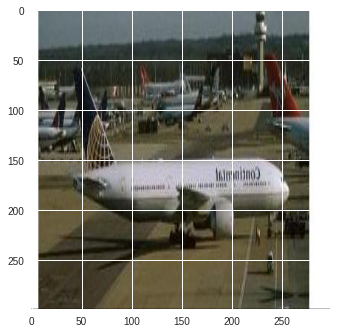

GRAD CAM REGULAR MODEL
label:	2


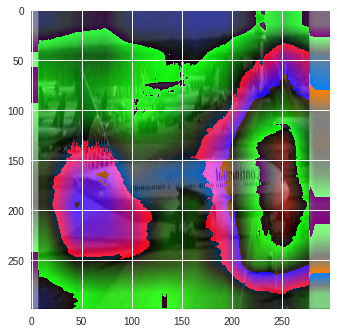

GRAD CAM COMPLEMENTARY MODEL
label:	2


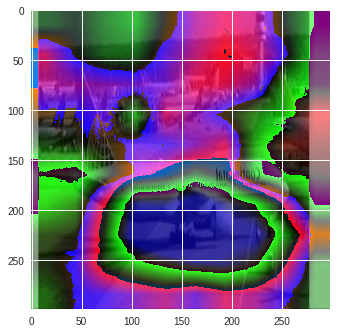

In [251]:
# AIRPLANE
for j in range(5):
  img = caltech_dict[2][1][j]
  print(img)
  print("ORIGINAL")
  show_img(convert_img_to_np(img))
  print("GRAD CAM REGULAR MODEL")
  show_gradcam(model, img, "block14_sepconv2_act")
  print("GRAD CAM COMPLEMENTARY MODEL")
  show_gradcam(cmodel, img, "block14_sepconv2_act")